In [20]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import re
import shapely

In [21]:

#You'll need to download the geopkg version of the Natural Earth dataset:
# https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/50m/physical/50m_physical.zip

land=gpd.read_file('/Volumes/ice1/ben/NaturalEarth/packages/natural_earth_vector.gpkg', layer = 'ne_50m_land')

In [22]:
land

,scalerank,featurecla,min_zoom,geometry
0,0,Land,1.5,"POLYGON ((179.99922 -16.16855, 179.84824 -16.3..."
1,0,Land,4.0,"POLYGON ((177.23418 -17.14707, 177.18281 -17.1..."
2,0,Land,4.0,"POLYGON ((127.37266 0.79131, 127.33838 0.75845..."
3,0,Land,3.0,"POLYGON ((-81.33481 24.65049, -81.36479 24.629..."
4,0,Land,4.0,"POLYGON ((-80.82939 24.80366, -80.84834 24.803..."
...,...,...,...,...
1415,0,Land,4.0,"POLYGON ((-166.10986 66.22744, -166.14863 66.2..."
1416,0,Land,4.0,"POLYGON ((-86.71401 21.23931, -86.69629 21.191..."
1417,0,Land,4.0,"POLYGON ((54.46543 24.44277, 54.45664 24.42334..."
1418,0,Land,4.0,"POLYGON ((-81.78384 24.54458, -81.80923 24.542..."


In [23]:
land_s=land.cx[:, :-60]

In [24]:
land_s

,scalerank,featurecla,min_zoom,geometry
50,0,Land,1.0,"POLYGON ((-120.55625 -73.75605, -120.37812 -73..."
51,0,Land,1.0,"POLYGON ((-126.32988 -73.28623, -126.06528 -73..."
52,0,Land,2.0,"POLYGON ((-66.17363 -80.07783, -66.26719 -80.0..."
53,0,Land,0.0,"POLYGON ((-57.846 -64.05391, -57.80854 -64.067..."
54,0,Land,2.0,"POLYGON ((-63.18057 -64.46953, -63.27695 -64.5..."
...,...,...,...,...
292,0,Land,3.0,"POLYGON ((-65.84526 -65.84248, -66.06392 -65.8..."
293,0,Land,3.0,"POLYGON ((-66.59531 -66.20068, -66.81865 -66.3..."
294,0,Land,3.0,"POLYGON ((-67.34893 -67.76621, -67.54453 -67.7..."
295,0,Land,3.0,"POLYGON ((-67.3624 -66.89453, -67.40923 -66.90..."


In [25]:
land_s_3857=land_s.to_crs(3857)

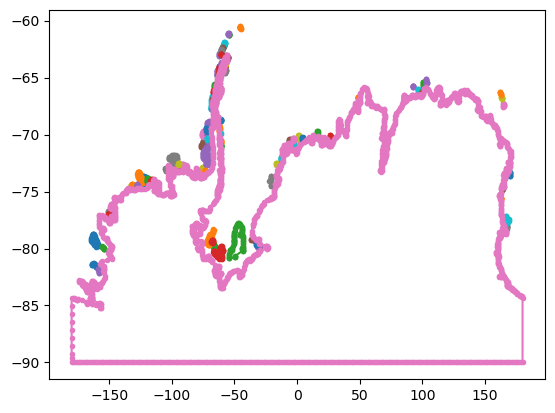

In [26]:
plt.figure()
for jj in land_s.geometry:
    plt.plot(*np.array(jj.exterior.coords).T, marker='.')

In [9]:
land_AA = shapely.unary_union(land_s_3857.geometry)

In [10]:
shelf_AA = shapely.unary_union(gpd.read_file('/Volumes/ice1/ben/NaturalEarth/packages/natural_earth_vector.gpkg', layer = 'ne_50m_antarctic_ice_shelves_polys').to_crs(3857).geometry)

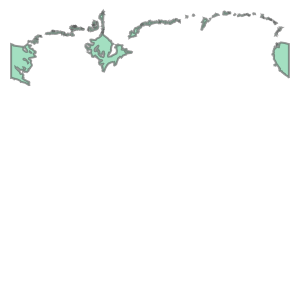

In [11]:
shelf_AA

In [45]:
import pyproj
to_wm = pyproj.Transformer.from_crs(4326, 3857)
clip_poly = shapely.Polygon(np.c_[to_wm.transform(*np.c_[bds[1][[0, 0, 1, 1, 0]], bds[0][[0, 1, 1, 0, 0]]].T)])

In [47]:
bds = [np.array([-179.9999, 179.9999]),  np.array([-89, -60])]

AA=shapely.unary_union([land_AA, shelf_AA]).buffer(1000)

In [49]:
for dist, name in zip([10e3, 50e3, 100e3, 500e3, 1000e3], ['10km','50km','100km','500km','1000km']):

    AA_buf = AA.buffer(-20000).buffer(20000).buffer(dist).intersection(clip_poly)


    temp=gpd.GeoDataFrame({'name':['Antarctica'], 'geometry':[AA_buf]}).set_crs(3857).to_crs(4326)
    with open(f'assets/Antarctica_{name}.geojson','w') as fh:
        fh.write(temp.to_json())

In [38]:
! ls assets

Antarctica_1000km.geojson  Antarctica_50km.geojson     land_mask.kml
Antarctica_100km.geojson   Antarctica.geojson	       new_points.csv
Antarctica_10km.geojson    IS2_RGTs_cycle12_date_time  warnings.txt


In [17]:
test=shapely.unary_union(gpd.read_file('assets/Antarctica_10km.geojson').to_crs(3857))

TypeError: One of the arguments is of incorrect type. Please provide only Geometry objects.

In [50]:
test=gpd.read_file('assets/Antarctica_10km.geojson')

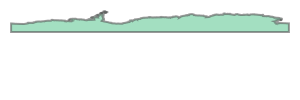

In [52]:
test.geometry[0]